# Self-Driving Car Engineer Nanodegree


## Project 3: Behavioral Cloning


---

In [160]:
import csv
import cv2
import keras
from keras.models import Sequential, model_from_json
from keras.layers.core import Activation, Dense, Dropout, Flatten, Lambda, Reshape
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import random
from sklearn.utils import shuffle


print(keras.__version__)

2.0.6


---
## Step 1: Load The Data

In [18]:
with open('data/udacity/driving_log.csv', newline='') as f:
    udacity_data = list(csv.reader(f, skipinitialspace=True, delimiter=',', quoting=csv.QUOTE_NONE))

print('total rows: ', len(udacity_data))
print(udacity_data[0])
udacity_data[1]

total rows:  8037
['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']


['IMG/center_2016_12_01_13_30_48_287.jpg',
 'IMG/left_2016_12_01_13_30_48_287.jpg',
 'IMG/right_2016_12_01_13_30_48_287.jpg',
 '0',
 '0',
 '0',
 '22.14829']

In [19]:

columns = udacity_data[0]
udacity_df = pd.read_csv('data/udacity/driving_log.csv', skiprows=[0], names=columns)

print('total rows: ', len(udacity_df))
udacity_df.head(n=10)

total rows:  8036


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236
5,IMG/center_2016_12_01_13_31_13_279.jpg,IMG/left_2016_12_01_13_31_13_279.jpg,IMG/right_2016_12_01_13_31_13_279.jpg,0.0,0.0,0.0,1.403993
6,IMG/center_2016_12_01_13_31_13_381.jpg,IMG/left_2016_12_01_13_31_13_381.jpg,IMG/right_2016_12_01_13_31_13_381.jpg,0.0,0.0,0.0,1.389892
7,IMG/center_2016_12_01_13_31_13_482.jpg,IMG/left_2016_12_01_13_31_13_482.jpg,IMG/right_2016_12_01_13_31_13_482.jpg,0.0,0.0,0.0,1.375934
8,IMG/center_2016_12_01_13_31_13_584.jpg,IMG/left_2016_12_01_13_31_13_584.jpg,IMG/right_2016_12_01_13_31_13_584.jpg,0.0,0.0,0.0,1.362115
9,IMG/center_2016_12_01_13_31_13_686.jpg,IMG/left_2016_12_01_13_31_13_686.jpg,IMG/right_2016_12_01_13_31_13_686.jpg,0.0,0.0,0.0,1.348435


---

## Step 2: Dataset Summary & Exploration

---



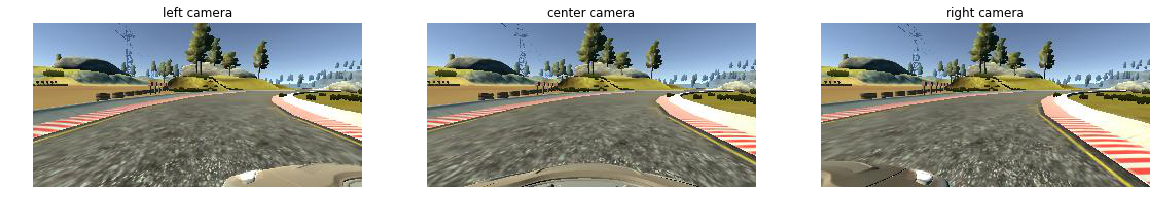

In [88]:
## Preview random set of images from each camera angle

# Display visualizations in the notebook
%matplotlib inline

index = random.randint(0, len(udacity_data))
img_dir = 'data/udacity/'

center_img = mpimg.imread(img_dir + udacity_data[index][0])
left_img = mpimg.imread(img_dir + udacity_data[index][1])
right_img = mpimg.imread(img_dir + udacity_data[index][2])

plt.figure(figsize=(20,5))

plt.subplot2grid((1, 3), (0, 0));
plt.axis('off')
plt.title('left camera')
plt.imshow(left_img, cmap="gray")

plt.subplot2grid((1, 3), (0, 1));
plt.axis('off')
plt.title('center camera')
plt.imshow(center_img, cmap="gray")

plt.subplot2grid((1, 3), (0, 2));
plt.axis('off')
plt.title('right camera')
plt.imshow(right_img, cmap="gray")

In [20]:
center = udacity_df.center.tolist()
# left = data.left.tolist()
# right = data.right.tolist()
steering = udacity_df.steering.tolist()

In [124]:
X_train = udacity_df.center.tolist()[0:2000]
y_train = udacity_df.steering.tolist()[0:2000]
X_valid = udacity_df.center.tolist()[2000:2500]
y_valid = udacity_df.steering.tolist()[2000:2500]

In [165]:
X_train[0]

'IMG/center_2016_12_01_13_30_48_287.jpg'

---
### Pre-process the Data Set

---
### Augmentation

Generates batches of tensor image data that is augmented based on a chosen set of tranformation parameters (e.g. rotation, shift, shear, zoom).

In [12]:
## Apply affine and color transformations 

import keras
from keras.preprocessing.image import ImageDataGenerator

# Transformations applied to RBG training images
datagen = keras.preprocessing.image.ImageDataGenerator(
    zca_whitening=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    channel_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=False,
    vertical_flip=False
)


Using TensorFlow backend.


---
### Grayscaling

In [115]:
## Create training, validation, and testing sets for GRAYSCALE images

from sklearn.model_selection import train_test_split

X_train_gray, X_test_gray, y_train_gray, y_test_gray = \
                train_test_split(X_train_gray, y_train_gray, test_size=0.2, random_state=12)
    
X_train_gray, X_valid_gray, y_train_gray, y_valid_gray = \
                train_test_split(X_train_gray, y_train_gray, test_size=0.1, random_state=55)

---
## Model Architecture
---

In [47]:
## Global variables and parameters

LOG_DIR = ".logs"
MODEL_DIR = ".models"
IMG_DIR = "data/udacity/"

epochs = 1
batch_size = 128

lr = 0.001         # learning rate
decay= 0.0001      # for L2 reg
mu = 0             # normalized mean
sigma = 0.1        # normalized stdev

### Generator

In [140]:
def generator(images, angles):
#     batch_train = np.zeros((batch_size, 64, 64, 3), dtype=np.float32)
#     batch_angle = np.zeros((batch_size,), dtype=np.float32)
    X_images = []
    y_angles = []
    while True:
        images, angles = shuffle(images, angles)
        for i in range(batch_size):
#             rand = int(np.random.choice(len(data), 1))
#             batch_train[i] = crop_resize(mpimg.imread(data[rand].strip()))
            image_path = IMG_DIR + images[i]
            image = mpimg.imread(image_path.strip())
#             resized = cv2.resize(image[60:140,:], (64,64))
#             batch_train[i] = cv2.resize(image[60:140,:], (64,64))
#             batch_angle[i] = angle[i]
            X_images.append(image)
            y_angles.append(angles[i])
#         print('X shape: ', X_images[0].shape)
        yield (np.array(X_images), np.array(y_angles))

In [118]:
X, y = generator(X_train, y_train)

X shape:  (64, 64, 3)


In [105]:
X[10].shape

(64, 64, 3)

### Operations

The series of functions below are designed to make the model more modular. This reduces the amount of hard-coding and makes it much easier to experiment with different model architectures.

### Model

In [156]:
shape_in = (160, 320, 3)
crop = ((70, 26), (0, 0))  # (top, bottom), (left, right)
shape_diff = ( (shape_in[0]-(crop[0][0]+crop[0][1])), shape_in[1], shape_in[2] )
shape_out = (64, 64 ,3)

drop = 0.5
reg = l2(0.001)
strides = (1, 1)
act = 'relu'
lr = 1e-4
default_pad = 'same'


In [157]:
shape_diff

(64, 320, 3)

In [166]:
model = Sequential()
model.add(Lambda(lambda x: x/255 - 0.5, input_shape=shape_in))
# model.add(Cropping2D(cropping=crop))
# model.add(Reshape(shape_out, input_shape=shape_diff))
model.add(Convolution2D(24, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Convolution2D(36, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Convolution2D(48, 5, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Convolution2D(64, 3, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(Convolution2D(64, 3, strides=strides, padding=default_pad, activation=act,  kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())
model.add(Dense(80, kernel_regularizer=reg))
model.add(Dropout(drop))
model.add(Dense(40, kernel_regularizer=reg))
model.add(Dropout(drop))
model.add(Dense(16, kernel_regularizer=reg))
model.add(Dropout(drop))
model.add(Dense(10, kernel_regularizer=reg))
model.add(Dense(1))

In [143]:
# Compile and train the model, 
model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error', metrics=['accuracy'])

model.summary()

train_gen = generator(X_train, y_train)
val_gen = generator(X_valid, y_valid)

train_steps = len(X_train) // batch_size
val_steps = len(X_valid) // batch_size

model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=epochs, validation_data=val_gen, validation_steps=val_steps)

print('Done Training')

# Save model and weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save("model.h5")
print("Saved model to disk")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_10 (Lambda)           (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 160, 320, 24)      1824      
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 160, 320, 36)      21636     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 160, 320, 48)      43248     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 80, 160, 48)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 80, 160, 64)       27712     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 80, 160, 64)       36928     
__________

KeyboardInterrupt: 